In [1]:
from IPython.core.pylabtools import figsize
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import linear_model, metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report, mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
import time
import warnings

In [2]:
def token_simple(data):
  model_checkpoint = "facebook/esm2_t12_35M_UR50D"
  from transformers import AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  y=data.iloc[:, -1]
  print("labels:", y.shape)
# before alignment
  fingerprint = []
  sequence = []
  for i in range(len(data)):
    compound, protein, interaction = data.iloc[i, :]

    mol = Chem.AddHs(Chem.MolFromSmiles(compound))
    fingerprint.append(np.array([int(i) for i in AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useChirality=True).ToBitString()]))
    sequence.append( np.array(tokenizer(protein,padding='max_length')['input_ids']))
# alignments
  sequence =pd.DataFrame(sequence)
  sequence= sequence.fillna(0)
# after alignments, combine different parts of data
  fingerprint=pd.DataFrame(fingerprint)
  X = pd.concat([fingerprint, sequence], axis=1)
  print("dataset:", X.shape)
  print("Number of positive/negative labels:", y.value_counts())
  return X, y

## Supervised Classification Models Comparison for Human Dataset

In [3]:
# change the directory to that of the CSV files.

current = os.getcwd()
os.chdir('../data/csv/')

print(os.getcwd())

C:\Users\nycdoe\Documents\badreeRoziena\project\data\csv


In [4]:
data = pd.read_csv('test_human.csv', header=None)
#data = data.sample(frac=1)
X, y = token_simple(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def evaluate(X_train, X_test, y_train, y_test):
    model_name_list = ['Linear Regression', 'ElasticNet Regression', 'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted','GaussianNB', 'MultinomialNB','Logistic Regression','Perceptron','Multi-Layer Perceptron']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    model7 = GaussianNB()
    model8 = MultinomialNB(alpha=0.5)
    model9 = LogisticRegression(solver='saga', random_state=0)
    model10 = Perceptron(penalty='l2', alpha=.1)
    model11 = MLPClassifier(random_state=42, hidden_layer_sizes=(3, ), alpha=0.01, max_iter=200,  activation='logistic')
    
    # Dataframe for results
    results = pd.DataFrame(columns=['rmse', 'r2'], index = model_name_list)
    df = pd.DataFrame()
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6,model7, model8, model9, model10, model11]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        # Metrics
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        r2 = r2_score(y_test, predictions)
        df['pred'] = pd.DataFrame(predictions)
        df['new_pred'] = df['pred'].apply(lambda x: 1 if x > 0 else 0)
        mod_pred = df['new_pred'].to_numpy()
        cm = confusion_matrix(y_test, mod_pred)
        print(model_name_list[i],rmse,r2,cm)
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [rmse, r2]
    return results

results = evaluate(X_train, X_test, y_train, y_test)
print(results)

labels: (4042,)


[12:18:09] WARNING: not removing hydrogen atom without neighbors
[12:18:11] WARNING: not removing hydrogen atom without neighbors
[12:18:20] WARNING: not removing hydrogen atom without neighbors


dataset: (4042, 5574)
Number of positive/negative labels: 0    3393
1     649
Name: 2, dtype: int64
Linear Regression 0.36374463700440585 0.04830765525477543 [[287 387]
 [ 17 118]]
ElasticNet Regression 0.3729455703661469 -0.0004474569700365638 [[  0 674]
 [  0 135]]
Random Forest 0.24271537655720382 0.5762614660951753 [[182 492]
 [  2 133]]
Extra Trees 0.22832111492456292 0.6250308561380371 [[246 428]
 [  4 131]]
SVM 0.2917371259111054 0.38780922859586986 [[  0 674]
 [  0 135]]
Gradient Boosted 0.30758582209423574 0.31948766052565736 [[  0 674]
 [  0 135]]
GaussianNB 0.7774637857773845 -3.34774151005605 [[199 475]
 [ 14 121]]
MultinomialNB 0.45570141808805686 -0.49370260468183313 [[617  57]
 [111  24]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression 0.3390527049176722 0.17312891526541374 [[666   8]
 [ 85  50]]
Perceptron 0.4085005291598245 -0.2002967359050445 [[674   0]
 [135   0]]
Multi-Layer Perceptron 0.4085005291598245 -0.2002967359050445 [[674   0]
 [135   0]]
                            rmse        r2
Linear Regression       0.363745  0.048308
ElasticNet Regression   0.372946 -0.000447
Random Forest           0.242715  0.576261
Extra Trees             0.228321  0.625031
SVM                     0.291737  0.387809
Gradient Boosted        0.307586  0.319488
GaussianNB              0.777464 -3.347742
MultinomialNB           0.455701 -0.493703
Logistic Regression     0.339053  0.173129
Perceptron              0.408501 -0.200297
Multi-Layer Perceptron  0.408501 -0.200297


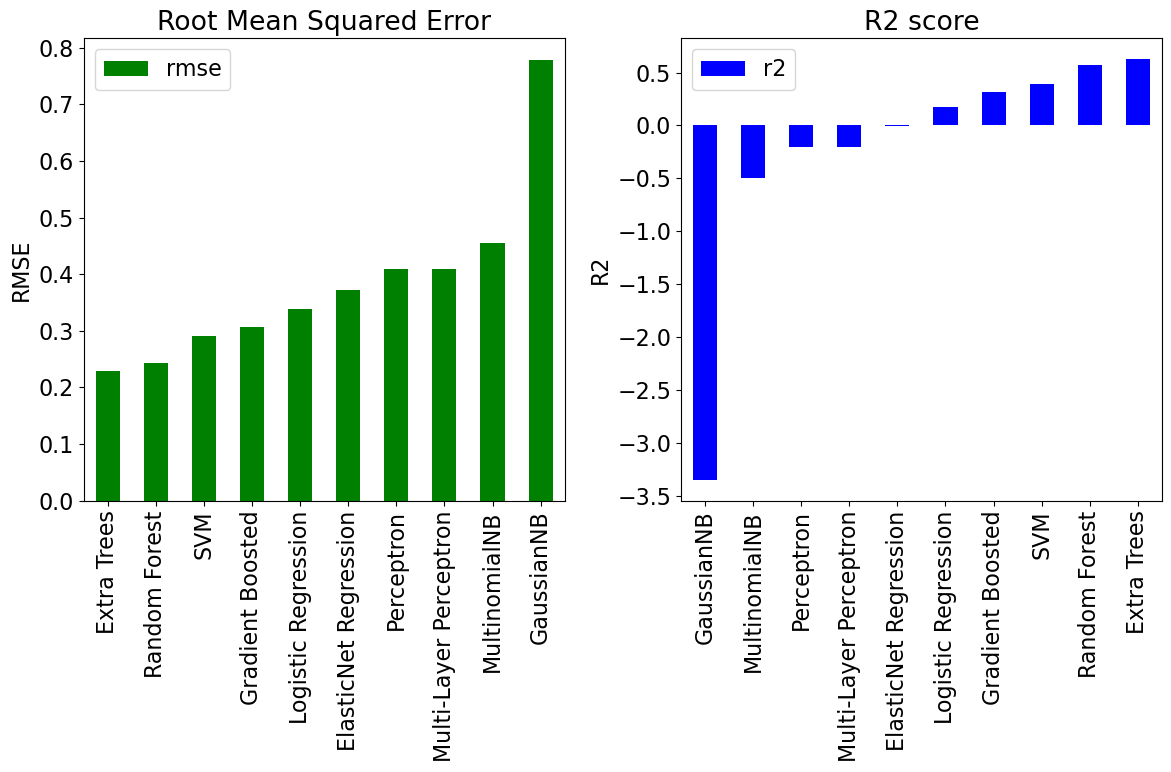

In [5]:
# plot the graph
figsize(12, 8)
plt.rcParams['font.size'] = 16
results = results[1:11]

# root mean squared error
ax = plt.subplot(1, 2, 1)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'g', ax = ax)
plt.title('Root Mean Squared Error'); plt.ylabel('RMSE');

# R2
ax = plt.subplot(1, 2, 2)
results.sort_values('r2', ascending = True).plot.bar(y = 'r2', color = 'b', ax = ax)
plt.title('R2 score'); plt.ylabel('R2');

plt.tight_layout()

In [6]:
# KNN

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,10), 'p': [1, 2, 10], 'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=2, verbose=3, n_jobs=-1)
knn_cv.fit(X_train.iloc[0:1000], y_train.iloc[0:1000])


params_optimal_knn = knn_cv.best_params_
print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

knn = KNeighborsClassifier(**params_optimal_knn)
y_test_pred = cross_val_predict(knn, X_test, y_test, cv=2)
print("\n RMSE: ", math.sqrt(mean_squared_error(y_test_pred,y_test)))
print("confusion_matrix:", confusion_matrix(y_test, y_test_pred))
precision = precision_score(y_test, y_test_pred) 
print("Precision = %f" % precision)
recall = recall_score(y_test, y_test_pred)
print("Recall = %f" % recall)
f1 = f1_score(y_test, y_test_pred)
print("F1 Score = %f" % f1)
auc= roc_auc_score(y_test,y_test_pred)
print("AUC:",auc)
y_scores = cross_val_predict(knn, X_test, y_test, method="predict_proba", cv=2)[:, 1]
auc= roc_auc_score(y_test,y_scores)
print("AUC with predict_proba:",auc)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best Score: 0.518030
Optimal Hyperparameter Values:  {'n_neighbors': 3, 'p': 10, 'weights': 'distance'}



 RMSE:  0.38513799238293983
confusion_matrix: [[645  29]
 [ 91  44]]
Precision = 0.602740
Recall = 0.325926
F1 Score = 0.423077
AUC: 0.641449609847236
AUC with predict_proba: 0.7084404879657105


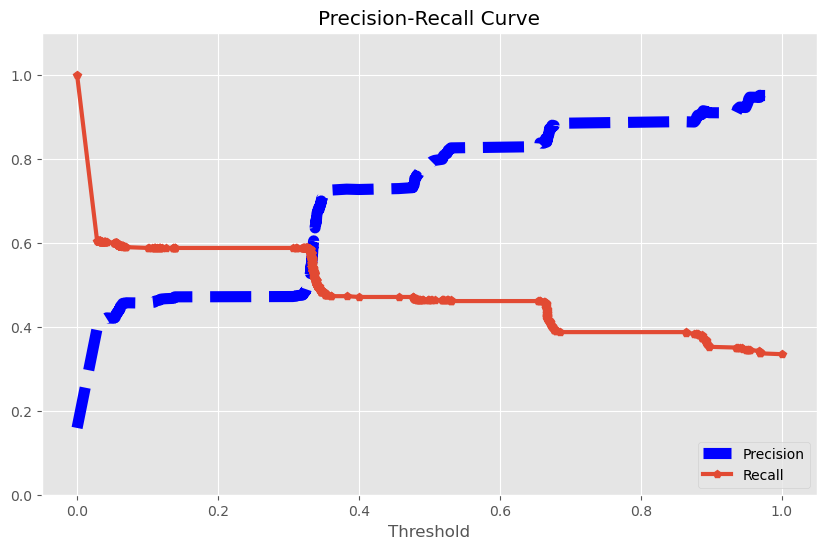

Optimal Threshold:  0.3333317048011251


In [7]:
# select the threshold value that gives the best precision/recall tradeoff for our problem

plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
# The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=2)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "p-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

## Unsupervised Learning Models for Classification

In [8]:
# data processing
data = pd.read_csv('test_human.csv', header=None)
data = data.sample(frac=1)
X, y = token_simple(data)

labels: (4042,)


[12:41:53] WARNING: not removing hydrogen atom without neighbors
[12:41:56] WARNING: not removing hydrogen atom without neighbors
[12:42:02] WARNING: not removing hydrogen atom without neighbors


dataset: (4042, 5574)
Number of positive/negative labels: 0    3393
1     649
Name: 2, dtype: int64


In [12]:
print(y.value_counts())

# Outlier
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=2)
y_pred = clf.fit_predict(X)
print((y_pred==1).sum(),(y_pred==-1).sum())
y_pred_update = np.where(y_pred==1,0,1)
print("LocalOutlierFactor result:", math.sqrt(mean_squared_error(y,y_pred_update)))
cm = confusion_matrix(y,y_pred_update)
print(cm)

# KMeans
from sklearn.cluster import KMeans
y_pred =KMeans(n_clusters=2, random_state=0).fit(X).labels_
print((y_pred==1).sum(),(y_pred==0).sum())
y_pred_update = np.where(y_pred==1,0,1)
print("KMeans result:", math.sqrt(mean_squared_error(y,y_pred_update)))
cm = confusion_matrix(y,y_pred_update)
print(cm)

0    3393
1     649
Name: 2, dtype: int64
3346 696
LocalOutlierFactor result: 0.4961504456517553
[[2872  521]
 [ 474  175]]
941 3101
KMeans result: 0.8349728223436074
[[ 758 2635]
 [ 183  466]]


In [13]:
# Spectral Clustering
#from sklearn.cluster import SpectralClustering
#y_pred = SpectralClustering(n_clusters=2, random_state=0,assign_labels='cluster_qr', degree=1).fit(X).labels_
#print((y_pred==1).sum(),(y_pred==0).sum())
#y_pred_update = np.where(y_pred==1,0,1)
#print("Spectral Clustering result:", math.sqrt(mean_squared_error(y,y_pred_update)))

# Affinity Propagation
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
print((labels==1).sum(),(labels==-1).sum())
labels = np.where(labels==1,0,1)
n_clusters_ = len(cluster_centers_indices)
print("Affinity Propagation----Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

0 4042
Affinity Propagation----Estimated number of clusters: 0
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
